#Convergence

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
\newcommand{\norm}[1]{||#1||}
$$

In this work session, we investigate the convergence of the simple scheme $\DdQq{1}{2}$ for the advection equation in dimension one. The same analysis could be done for other schemes or other dimensions. 

##The $\DdQq{1}{2}$ for advection

We consider the problem
$$\drondt u + c\drondx u = 0,\qquad t>0, \qquad x\in(0,1),$$
with periodic boundary conditions (in order to not perturb the convergence rate). 
The simulation is performed with the following scheme
* the scheme velocity $\lambda=1$,
* the two velocities $v_0=1$, $v_1=-1$,
* the polynomials $P_0=1$, $P_1=X$ that defines the moments,
* the first moment $u$ is conserved and the second moment $v$ that relaxes toward its equilibrium value $cu$,
* the relaxation parameter $s\in[0,2]$.

####Question 1

Propose a dictionary for this $\DdQq{1}{2}$. 

####Question 2

Test the dictionary on a very simple test case: $s=1.$, $c=0.5$, $\dx=0.1$, and $$u(x,t=0) = \left\{ \begin{aligned} 1&\quad \text{if } 0<x<0.1, \\ 0 &\quad \text{else.} \end{aligned} \right. $$
In particular, plot the solution at several time.

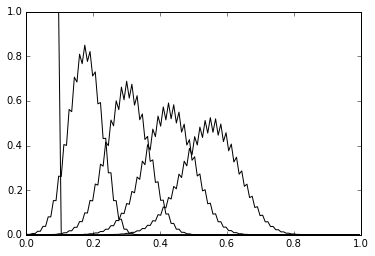

In [1]:
import numpy as np
import sympy as sp
import pylab as plt
%matplotlib inline
import pyLBM

u, X = sp.symbols('u, X')

def u0(x):
    return 1.*(x<.1)

Tf = 1.
c = 0.5
s = 1.
N = 128

dico = {
    'box':{'x':[0., 1.], 'label':-1},
    'scheme_velocity':1.,
    'space_step':1./N,
    'schemes':[
        {
            'velocities':[1,2],
            'conserved_moments':u,
            'polynomials':[1, X],
            'equilibrium':[u, c*u],
            'relaxation_parameters':[0., s],
            'init':{u:(u0,)},
        },
    ],
    'generator':pyLBM.CythonGenerator,
}
sol = pyLBM.Simulation(dico)
x = sol.domain.x[0][1:-1]
y = sol.m[0][0][1:-1]
plt.figure()
plt.clf()
sol.f2m()
plt.plot(x, y, 'k')
compt = 0
while sol.t < Tf:
    sol.one_time_step()
    compt += 1
    if compt == 32:
        sol.f2m()
        plt.plot(x, y, 'k')
        compt = 0
plt.show()

##Convergence rate for smooth solutions

The Taylor analysis of the scheme (order of consistancy) can be justify for a smooth solution. We then compute the numerical convergence rate with a smooth initial function.

####Question 3

Propose a function `solution(x, t)` that is a smooth solution of the advection equation. It could be build with piecewise polynomial functions. 

####Question 4

Compute the numerical solution given by the $\DdQq{1}{2}$ and compare it to the exact solution.

####Question 5

Compute the error ($L^1$-norm) for several space steps (the space step could be $\dx=2^{-k}$ for k integer). Evaluate the order of the convergence of this scheme.

In [2]:
def solution(x, t):
    a, b = 0., 1.
    milieu = 0.5*(a+b)
    largeur = 0.1*(b-a)
    milieu -= 0.5*c*Tf
    y = x - c*t
    return 1.0/largeur**8 * (y-milieu-largeur)**4 * (milieu-y-largeur)**4 * (abs(y-milieu)<largeur)

def test(c, s, N):
    dico = {
        'box':{'x':[0., 1.], 'label':-1},
        'scheme_velocity':1.,
        'space_step':1./N,
        'schemes':[
            {
                'velocities':[1,2],
                'conserved_moments':u,
                'polynomials':[1, X],
                'equilibrium':[u, c*u],
                'relaxation_parameters':[0., s],
                'init':{u:(solution, (0.,))},
            },
        ],
        'generator':pyLBM.CythonGenerator,
    }
    sol = pyLBM.Simulation(dico)
    while sol.t < Tf:
        sol.one_time_step()
    sol.f2m()
    x = sol.domain.x[0][1:-1]
    y = sol.m[0][0][1:-1]
    return sol.domain.dx * np.linalg.norm(y - solution(x, sol.t), 1)

Tf = .4
c = 0.75
s = 1.

vdx = []
vE = []
for k in xrange(6,15):
    N = 2**k
    erreur = test(c, s, N)
    print "k={0:2d}, N={1:5d}, E={2:8.2e}".format(k, N, erreur)
    vdx.append(1./N)
    vE.append(erreur)
slope = (np.log2(vE[-1]) - np.log2(vE[-2])) / (np.log2(vdx[-1]) - np.log2(vdx[-2]))
print "order of convergence: {0:8.6f}".format(slope)

k= 6, N=   64, E=5.21e-02
k= 7, N=  128, E=3.44e-02
k= 8, N=  256, E=2.05e-02
k= 9, N=  512, E=1.14e-02
k=10, N= 1024, E=6.09e-03
k=11, N= 2048, E=3.15e-03
k=12, N= 4096, E=1.60e-03
k=13, N= 8192, E=8.07e-04
k=14, N=16384, E=4.05e-04
order of convergence: 0.993745


##Convergence rate for discontinuous solutions

####Question 6

Compute the order of convergence for a discontinuous solution by changing the initialization.

In [3]:
def solution(x, t):
    a, b = 0., 1.
    milieu = 0.5*(a+b)
    largeur = 0.1*(b-a)
    milieu -= 0.5*c*Tf
    y = x - c*t
    return abs(y-milieu)<largeur

Tf = .4
c = 0.75
s = 1.

vdx = []
vE = []
for k in xrange(6,15):
    N = 2**k
    erreur = test(c, s, N)
    print "k={0:2d}, N={1:5d}, E={2:8.2e}".format(k, N, erreur)
    vdx.append(1./N)
    vE.append(erreur)
slope = (np.log2(vE[-1]) - np.log2(vE[-2])) / (np.log2(vdx[-1]) - np.log2(vdx[-2]))
print "order of convergence: {0:8.6f}".format(slope)

k= 6, N=   64, E=8.73e-02
k= 7, N=  128, E=6.00e-02
k= 8, N=  256, E=4.17e-02
k= 9, N=  512, E=2.96e-02
k=10, N= 1024, E=2.09e-02
k=11, N= 2048, E=1.48e-02
k=12, N= 4096, E=1.04e-02
k=13, N= 8192, E=7.38e-03
k=14, N=16384, E=5.22e-03
order of convergence: 0.499945


In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()